# Classification - FastText

This notebook discusses Multi-label classificaon methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in [FastText](https://radimrehurek.com/gensim_3.8.3/models/fasttext.html#module-gensim.models.fasttext) representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import load
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths

RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

In [3]:
from academia_tag_recommender.experiments.transformer import FastTextTransformer
from academia_tag_recommender.experiments.experimental_classifier import ExperimentalClassifier

transformer = FastTextTransformer.load('fasttext')
train = transformer.fit(X_train)

In [4]:
test = transformer.transform(X_test)

<a id='data_preparation'/>

## Data Preparation

In [5]:
def create_classifier(classifier, name):
    experimental_classifier = ExperimentalClassifier.load(transformer, classifier, name)
    #experimental_classifier.train(train, y_train)
    #experimental_classifier.score(test, y_test)
    print('Training: {}s'.format(experimental_classifier.training_time))
    print('Test: {}s'.format(experimental_classifier.test_time))
    experimental_classifier.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classwise Classifier](#classwise)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [6]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 150.64775848388672s
Test: 0.0724949836730957s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02231718958823904      0.007738814993954051     0.18257355904877065      0.17943369609028614      0.16525940001151607      
micro                                                            0.17021771492370674      0.17516396189381972      0.17265542054972277      
macro                                                            0.07507500358282736      0.07594597099752906      0.07526479302738212      


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 1.431675672531128s
Test: 146.79207563400269s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013051613313816586     0.06444981862152357      0.36264409512293433      0.21443571140669085      0.2506884704708163       
micro                                                            0.5236440362417774       0.20197232993441525      0.29150832584813097      
macro                                                            0.352229729597217        0.08998511100332149      0.128740892568051        


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [8]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Training: 256.7573256492615s
Test: 0.16458463668823242s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011471393113982053     0.0871825876662636       0.48583635630794036      0.2887726723095526       0.33744352315694515      
micro                                                            0.6681935635424008       0.2723442960409785       0.38696731626024555      
macro                                                            0.48471625483238556      0.1733436889053663       0.23384628955256498      


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [9]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 47.60919141769409s
Test: 0.793205976486206s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011817603258448418     0.07690447400241839      0.3621221281741233       0.1964087061668682       0.23850031669257785      
micro                                                            0.7197802197802198       0.1818660539039686       0.2903657278251232       
macro                                                            0.32915220162743863      0.0785499578498959       0.11177009581454884      


In [10]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 46.65491700172424s
Test: 0.7899377346038818s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012119900719149748     0.07085852478839177      0.31003627569528414      0.166975010076582        0.2032204756146715       
micro                                                            0.6990291262135923       0.15510555794915984      0.2538787023977433       
macro                                                            0.2632013276574044       0.04823110105719813      0.07238808093588582      


<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [11]:
from skmultilearn.problem_transform import ClassifierChain

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Training: 106.8448657989502s
Test: 3.7277584075927734s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011748233946413798     0.081136638452237        0.4053204353083434       0.22501209189842805      0.2708665860540105       
micro                                                            0.6913502442098629       0.21006271243238067      0.3222205903950654       
macro                                                            0.37670353905822457      0.09501948784845518      0.13340065090074715      


In [12]:
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Training: 99.22460198402405s
Test: 4.282824516296387s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012089989180932986     0.0720677146311971       0.34634018540910927      0.18948004836759375      0.22880981171186734      
micro                                                            0.6717501815541032       0.1771267174110776       0.28033488654013716      
macro                                                            0.2779889762967602       0.053631912166168125     0.07891473257993525      


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [13]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.svm import LinearSVC

create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

Training: 1641.7068870067596s
Test: 1.6131377220153809s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013134983771399478     0.059492140266021766     0.5337726723095525       0.2715618702136235       0.3397242855223508       
micro                                                            0.5121147509207211       0.25295610129733354      0.3386419713525811       
macro                                                            0.3236125840323931       0.1311399322398971       0.16573927303804104      


In [14]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import LogisticRegression

create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

Training: 1607.7394404411316s
Test: 2.0751357078552246s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013395277795455992     0.04812575574365175      0.4915356711003628       0.21637646110439337      0.2872591696896413       
micro                                                            0.49053233297606286      0.19718512135573746      0.28129481663593525      
macro                                                            0.11456032040161158      0.04607865567317065      0.05312670781730996      


<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [15]:
from skmultilearn.adapt import MLkNN

create_classifier(MLkNN(), 'MLkNN')

Training: 383.06043577194214s
Test: 94.63983607292175s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01270222109081652      0.06444981862152357      0.3739016525594518       0.2158121725110842       0.2547167040939713       
micro                                                            0.561769394261424        0.202451050792283        0.29763873737551466      
macro                                                            0.35752726989590816      0.10811322880903744      0.14816032472863527      


<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [16]:
from skmultilearn.adapt import MLARAM

create_classifier(MLARAM(), 'MLARAM')

Training: 41.28285002708435s
Test: 289.4158363342285s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.016644816394068604     0.0467956469165659       0.44676129557336947      0.31394397420395004      0.3296643183908599       
micro                                                            0.35139712108382726      0.29800373402269137      0.32250543985079266      
macro                                                            0.22363542050408383      0.13995799306550633      0.15535116777164093      


<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [17]:
from skmultilearn.ensemble import RakelO

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Training: 259.9254927635193s
Test: 155.50337266921997s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012008527970470311     0.07194679564691657      0.32380088673921803      0.16805925030229746      0.20788766050555652      
micro                                                            0.7272727272727273       0.15472258126286562      0.25516125212173846      
macro                                                            0.21724842282820506      0.04998885175813049      0.0725436863419079       


In [18]:
create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Training: 640.3081767559052s
Test: 141.85892057418823s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011983707757907466     0.07363966142684401      0.3426199113260782       0.18829101168883514      0.22716732884205676      
micro                                                            0.6939159917121869       0.17636076403848916      0.2812428429651118       
macro                                                            0.3120614170939287       0.06305481974764734      0.0934439660334214       


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [19]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Training: 99.58949589729309s
Test: 51.59477400779724s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011984344173614206     0.07146311970979444      0.3292120112857718       0.1701894397420395       0.210855357862613        
micro                                                            0.7271523178807947       0.15769065058164583      0.25917620677446         
macro                                                            0.22977653528049952      0.05206903471215569      0.07481310456983493      


In [20]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Training: 147.74398136138916s
Test: 46.264888525009155s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011971615859479413     0.07363966142684401      0.3473921805723499       0.1927831519548569       0.2317708873150227       
micro                                                            0.6907822254865956       0.18009478672985782      0.2857034364913613       
macro                                                            0.3076316875256255       0.0663016167353871       0.09784433532526046      


***Clustering***

In [21]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

def get_graph_builder():
    graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
    label_names = get_all_labels()
    edge_map = graph_builder.transform(y_train)
    print("{} labels, {} edges".format(len(label_names), len(edge_map)))
    return graph_builder

In [22]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

def get_clusterer():
    graph_builder = get_graph_builder()
    clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
    partition = clusterer_igraph.fit_predict(X_train, y_train)
    return clusterer_igraph

In [23]:
clusterer_igraph = get_clusterer()

190 labels, 7716 edges


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [24]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Training: 376.30184507369995s
Test: 8.842415571212769s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011998981734869216     0.07339782345828295      0.364248286981056        0.19520959290608628      0.23829129959117865      
micro                                                            0.680953227814334        0.18330221647757192      0.28885033192516596      
macro                                                            0.32219450363079927      0.06620624085379642      0.09849204359476776      


In [25]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

Training: 972.896520614624s
Test: 8.364319086074829s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011872971424934767     0.07424425634824668      0.35460499798468353      0.18545546150745668      0.22878591581735472      
micro                                                            0.7252370385313698       0.17210014840346594      0.27818617967964093      
macro                                                            0.32811898996144184      0.07459036901677858      0.10840228605041911      


<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [26]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

Training: 495.80758237838745s
Test: 3.8196017742156982s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011998981734869216     0.07339782345828295      0.364248286981056        0.19520959290608628      0.23829129959117865      
micro                                                            0.680953227814334        0.18330221647757192      0.28885033192516596      
macro                                                            0.32219450363079927      0.06620624085379642      0.09849204359476776      


In [27]:
create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

Training: 1112.1030058860779s
Test: 4.199321508407593s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011872971424934767     0.07424425634824668      0.35460499798468353      0.18545546150745668      0.22878591581735472      
micro                                                            0.7252370385313698       0.17210014840346594      0.27818617967964093      
macro                                                            0.32811898996144184      0.07459036901677858      0.10840228605041911      


<a id='evaluation'/>

## Evaluation

In [28]:
paths = available_classifier_paths('fasttext')
evals = []
for path in paths:
    if '-' not in path.name:
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([str(clf), evaluation])

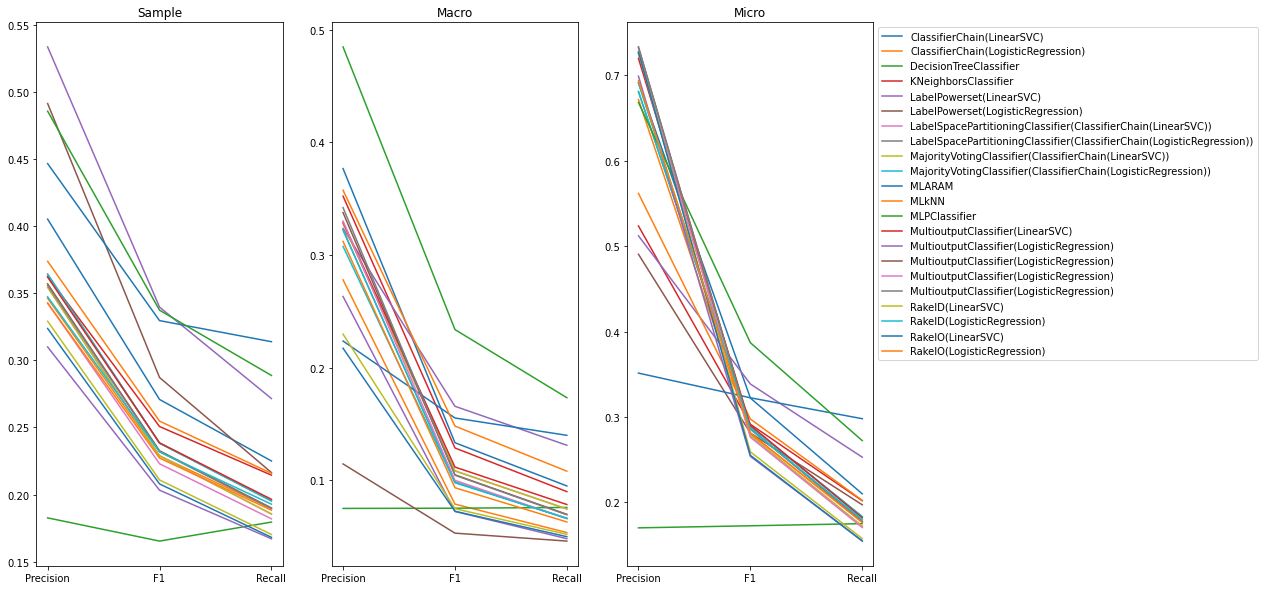

In [29]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [30]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [31]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray() 
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [32]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    if '-' not in clf_path.name:
        clf = load(clf_path)
        prediction = clf.predict(test)
        label_accuracies = per_label_accuracy(y_test, prediction)
        report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
        classwise_report = {}
        for i, result in enumerate(report):
            if i < len(label_accuracies):
                classwise_report[result] = report[result]
                classwise_report[result]['accuracy'] = label_accuracies[int(result)]
        classwise_results.append((clf, classwise_report))

In [33]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()

**Impact of vector size**

In [34]:
transformer = FastTextTransformer.load('fasttext', 100)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 46.65491700172424s
Test: 0.7899377346038818s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012119900719149748     0.07085852478839177      0.31003627569528414      0.166975010076582        0.2032204756146715       
micro                                                            0.6990291262135923       0.15510555794915984      0.2538787023977433       
macro                                                            0.2632013276574044       0.04823110105719813      0.07238808093588582      


In [35]:
transformer = FastTextTransformer.load('fasttext', 200)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 285.0447142124176s
Test: 2.510732412338257s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011879971997708903     0.07412333736396615      0.34282547359935506      0.1818540910923015       0.22291472332584786      
micro                                                            0.7265497553017944       0.17056824165828904      0.2762765091303842       
macro                                                            0.3300697981905532       0.06610394537677874      0.10000397068064278      


In [36]:
transformer = FastTextTransformer.load('fasttext', 500)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 413.733681678772s
Test: 4.350580930709839s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01179596512441927      0.0761789600967352       0.35611850060459493      0.18951027811366383      0.2319712673461162       
micro                                                            0.7323332017370706       0.17760543826894537      0.2858794066653824       
macro                                                            0.34204609888382553      0.0694175990523228       0.10454733755511275      


In [37]:
transformer = FastTextTransformer.load('fasttext', 1000)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 703.9492161273956s
Test: 8.65995168685913s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011788964551645135     0.07629987908101572      0.35706569931479243      0.1899556630390971       0.2325796049979847       
micro                                                            0.7332807259814559       0.17794054286945282      0.28638569997688573      
macro                                                            0.33762365521140414      0.06983702715810762      0.10489411990142933      


In [38]:
import re
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths
paths = available_classifier_paths('fasttext', 'size')
evals = []
for path in paths:
    if 'MultioutputClassifier(LogisticRegression)' in str(path):
        clf = load(path)
        evaluation = clf.evaluation
        matches = re.findall(r'=([\w,\d]*)', str(path))
        _, _, size = matches
        evals.append([int(size), evaluation])

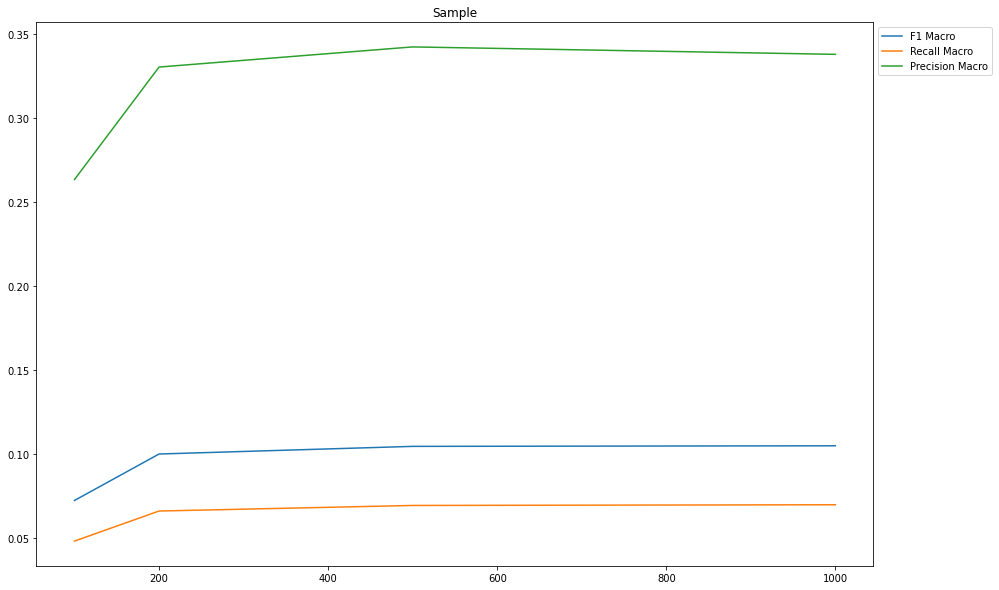

In [39]:
fig, axes = plt.subplots(figsize=(15,10))
axes.set_title('Sample')
evals = sorted(evals, key=lambda x: x[0])
x_ = [eval[0] for eval in evals]
axes.plot(x_, [eval[1].f1_macro for eval in evals], label='F1 Macro')
axes.plot(x_, [eval[1].recall_macro for eval in evals], label='Recall Macro')
axes.plot(x_, [eval[1].precision_macro for eval in evals], label='Precision Macro')
axes.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()